In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve, train_test_split
from xgboost import XGBClassifier
import joblib
import os
# from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    confusion_matrix, roc_curve, auc
)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance
from matplotlib import pyplot

In [4]:
#Loading the data
data0 = pd.read_csv(r'Dataset\FinalDataset_Normalized_features_minmax.csv')
data0.head()

,src_ip,dst_ip,src_port,dst_port,proto,duration,avg_duration,duration_std_dev,dur_percent_std_dev,orig_payload_size,resp_payload_size,payload_ratio,inbound_packets,outbound_packets,avg_periodicity,periodicity_std,ssl_flow_ratio,ssl_tls_ratio,Label
0,192.168.0.1,192.168.0.100,53,40478,UDP,8.837869e-07,0.000002,0.000001,0.012549,0.000000e+00,0.000000e+00,0.000000e+00,1.625554e-07,1.610521e-07,0.000000,0.000000,0.000000,0.000000,Normal
1,192.168.0.1,192.168.0.100,53,33807,UDP,8.898048e-07,0.000002,0.000001,0.012550,0.000000e+00,0.000000e+00,0.000000e+00,1.625554e-07,1.610521e-07,0.000000,0.000000,0.000000,0.000000,Normal
2,192.168.0.100,20.189.173.28,443,41128,TCP,7.092157e-03,0.001374,0.001565,0.025091,4.355250e-09,2.132526e-08,3.755685e-06,2.600886e-06,1.127365e-06,0.000753,0.001252,0.006408,0.666667,Normal
3,192.168.0.100,40.79.167.8,443,45780,TCP,6.760897e-05,0.000013,0.000013,0.022429,1.064050e-06,6.443452e-07,4.644774e-07,1.788109e-06,2.093677e-06,0.000011,0.000013,0.015220,0.666667,Normal
4,100.20.43.245,192.168.0.100,443,40422,TCP,1.764693e-03,0.001966,0.001942,0.021754,0.000000e+00,0.000000e+00,0.000000e+00,4.876662e-07,1.610521e-07,0.001930,0.001930,0.000000,0.000000,Normal


In [5]:
sizes = data0['Label'].value_counts(sort=1)
print(sizes)

Label
Normal        54541
Ransomware    35188
Name: count, dtype: int64


In [6]:
data0.shape

(89729, 19)

In [7]:
#Listing the features of the dataset
data0.columns

Index(['src_ip', 'dst_ip', 'src_port', 'dst_port', 'proto', 'duration',
       'avg_duration', 'duration_std_dev', 'dur_percent_std_dev',
       'orig_payload_size', 'resp_payload_size', 'payload_ratio',
       'inbound_packets', 'outbound_packets', 'avg_periodicity',
       'periodicity_std', 'ssl_flow_ratio', 'ssl_tls_ratio', 'Label'],
      dtype='object')

In [8]:
#Information about the dataset
data=data0
data0=data0.drop(['Label'], axis=1)
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89729 entries, 0 to 89728
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   src_ip               89729 non-null  object 
 1   dst_ip               89729 non-null  object 
 2   src_port             89729 non-null  int64  
 3   dst_port             89729 non-null  int64  
 4   proto                89729 non-null  object 
 5   duration             89729 non-null  float64
 6   avg_duration         89729 non-null  float64
 7   duration_std_dev     89729 non-null  float64
 8   dur_percent_std_dev  89729 non-null  float64
 9   orig_payload_size    89729 non-null  float64
 10  resp_payload_size    89729 non-null  float64
 11  payload_ratio        89729 non-null  float64
 12  inbound_packets      89729 non-null  float64
 13  outbound_packets     89729 non-null  float64
 14  avg_periodicity      89729 non-null  float64
 15  periodicity_std      89729 non-null 

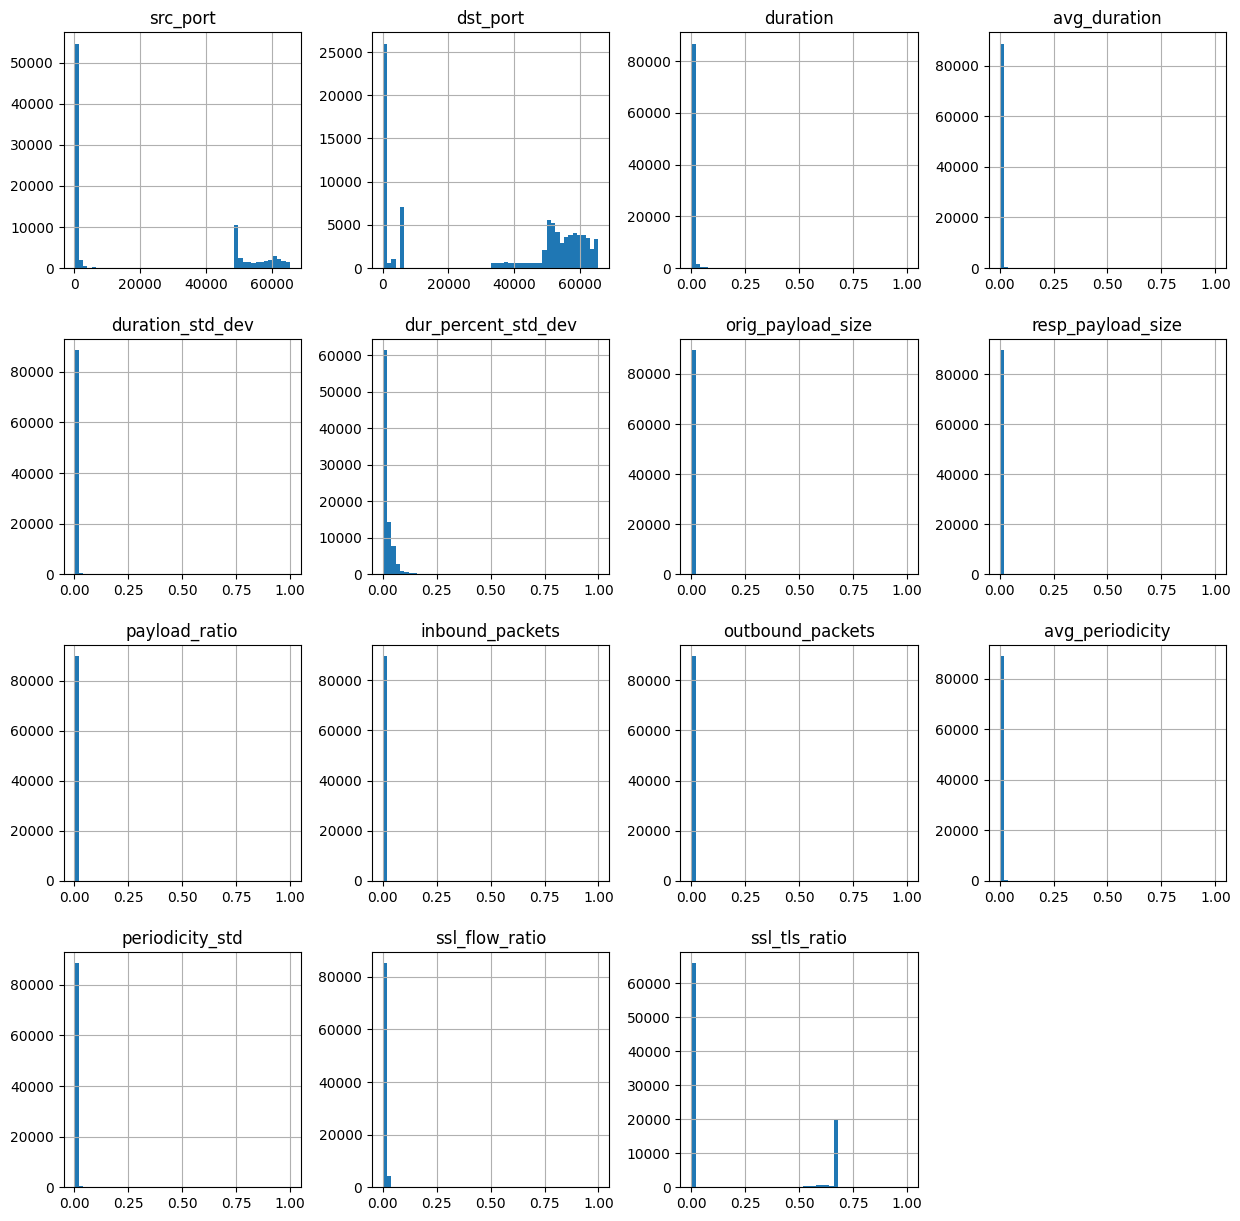

In [9]:
#Plotting the data distribution
data0.hist(bins = 50,figsize = (15,15))
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_20364\3069295317.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df["Label"].replace({"Normal": 0, "Ransomware": 1})


Explained Variance Ratio: [0.32638333 0.30257056 0.1411058 ]


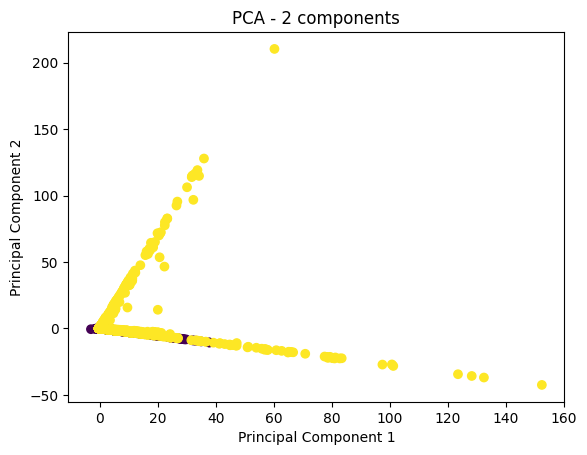

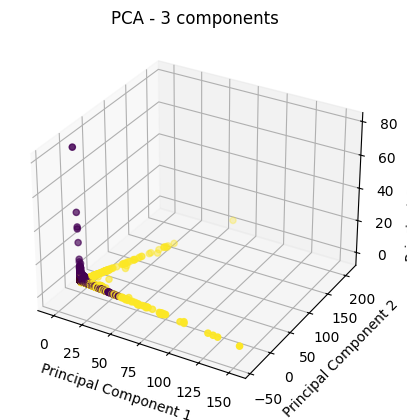

In [10]:
df = data
X = df.drop(columns=['src_ip', 'dst_ip', 'src_port', 'dst_port', 'proto','Label'])
y = df["Label"].replace({"Normal": 0, "Ransomware": 1})

# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=3)  # You can choose how many components you want
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio to see how much variance each component explains
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")

# Plotting the first two principal components
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - 2 components')
plt.show()


# 3D plot for the first three principal components
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA - 3 components')

plt.show()


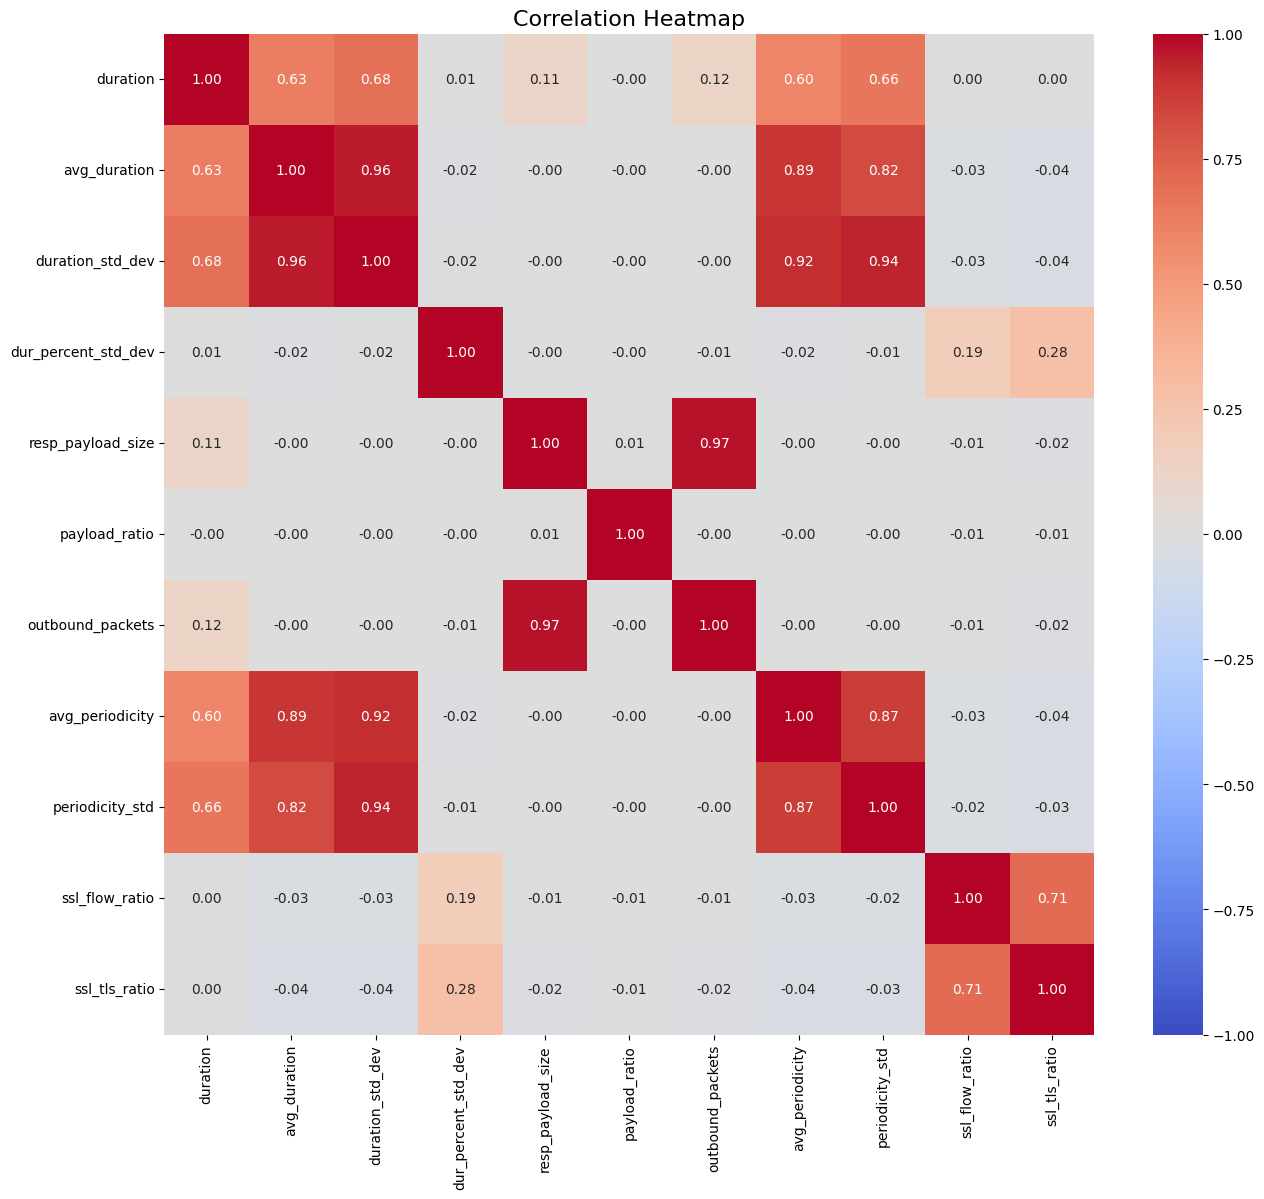

In [11]:
#Correlation heatmap


corr_matrix = data0.drop(['src_ip', 'dst_ip', 'src_port', 'dst_port', 'proto','orig_payload_size','inbound_packets'], axis=1).corr()

# Plot the heatmap
plt.figure(figsize=(15, 13))
sns.heatmap(corr_matrix, annot=True, fmt=".2f",vmax= 1, vmin= -1, cmap="coolwarm")
plt.title("Correlation Heatmap", fontsize=16)
plt.show()


In [12]:
data0.describe()

,src_port,dst_port,duration,avg_duration,duration_std_dev,dur_percent_std_dev,orig_payload_size,resp_payload_size,payload_ratio,inbound_packets,outbound_packets,avg_periodicity,periodicity_std,ssl_flow_ratio,ssl_tls_ratio
count,89729.000000,89729.000000,89729.000000,89729.000000,89729.000000,89729.000000,8.972900e+04,8.972900e+04,8.972900e+04,8.972900e+04,8.972900e+04,89729.000000,89729.000000,89729.000000,89729.000000
mean,20026.081367,33956.391044,0.003138,0.001003,0.001148,0.022235,2.603824e-04,2.722321e-04,9.691082e-05,2.949979e-04,2.867515e-04,0.000891,0.001070,0.003513,0.172638
std,26467.267981,26552.343462,0.023121,0.012488,0.013458,0.035684,8.925057e-03,9.043353e-03,7.341270e-03,9.419181e-03,9.191879e-03,0.012023,0.013733,0.008287,0.289112
min,53.000000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,137.000000,443.000000,0.000002,0.000003,0.000002,0.008991,0.000000e+00,0.000000e+00,0.000000e+00,1.625554e-07,1.610521e-07,0.000000,0.000000,0.000000,0.000000
50%,443.000000,50073.000000,0.000024,0.000012,0.000011,0.012716,1.518116e-08,1.314231e-08,6.289953e-07,3.251108e-07,6.442084e-07,0.000001,0.000002,0.000000,0.000000
75%,49770.000000,57071.000000,0.000409,0.000080,0.000124,0.025448,2.864510e-07,7.302661e-07,2.277869e-06,1.950665e-06,1.932625e-06,0.000046,0.000082,0.003581,0.577778
max,65535.000000,65535.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000


In [13]:
data.isnull().sum()

src_ip                 0
dst_ip                 0
src_port               0
dst_port               0
proto                  0
duration               0
avg_duration           0
duration_std_dev       0
dur_percent_std_dev    0
orig_payload_size      0
resp_payload_size      0
payload_ratio          0
inbound_packets        0
outbound_packets       0
avg_periodicity        0
periodicity_std        0
ssl_flow_ratio         0
ssl_tls_ratio          0
Label                  0
dtype: int64

In [14]:
data.columns.values

array(['src_ip', 'dst_ip', 'src_port', 'dst_port', 'proto', 'duration',
       'avg_duration', 'duration_std_dev', 'dur_percent_std_dev',
       'orig_payload_size', 'resp_payload_size', 'payload_ratio',
       'inbound_packets', 'outbound_packets', 'avg_periodicity',
       'periodicity_std', 'ssl_flow_ratio', 'ssl_tls_ratio', 'Label'],
      dtype=object)

In [15]:
# Drop unnecessary columns
data = data.drop(['src_ip', 'dst_ip', 'src_port', 'dst_port', 'proto','orig_payload_size','inbound_packets'], axis=1)

# Shuffle the dataset
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the dataset structure after dropping and shuffling
data.head()


,duration,avg_duration,duration_std_dev,dur_percent_std_dev,resp_payload_size,payload_ratio,outbound_packets,avg_periodicity,periodicity_std,ssl_flow_ratio,ssl_tls_ratio,Label
0,0.000006,0.000002,0.000002,0.009325,8.133354e-08,2.695378e-07,1.288417e-06,9.932169e-07,0.000001,0.000000,0.000000,Ransomware
1,0.002619,0.000006,0.000074,0.283989,2.153630e-04,2.354974e-05,7.811027e-05,5.434883e-06,0.000091,0.000000,0.000000,Normal
2,0.036508,0.003320,0.006847,0.045425,4.760988e-08,3.316017e-07,5.314719e-06,3.023945e-03,0.008263,0.026927,0.666667,Normal
3,0.000031,0.000069,0.000040,0.000000,0.000000e+00,0.000000e+00,3.221042e-07,0.000000e+00,0.000000,0.000000,0.000000,Ransomware
4,0.000021,0.000003,0.000004,0.028109,7.995732e-07,7.869348e-07,2.093677e-06,2.458104e-06,0.000005,0.000000,0.000000,Normal


In [16]:
# feature_cols = ['In.....']
# y = data.Label # Target variable
# data = data.drop('Label',axis=1)
# X = data[feature_cols] # Features

# Sepratating & assigning features and target columns to X & y
y = data['Label']
X = data.drop('Label',axis=1)
X.shape, y.shape
# clf = tree.DecisionTreeClassifier()
# clf = clf.fit(X, y)
# print(clf.tree_.max_depth)

((89729, 11), (89729,))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.40, random_state = 100)
X_train.shape, X_test.shape

# Step 2: Encode the labels AFTER splitting
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # Fit & transform on train labels
y_test = label_encoder.transform(y_test)  # Transform test labels using the same encoder

# Decision Tree

Decision Tree Training Time: 0.08 seconds
Accuracy: 0.9935
Precision: 0.9936
Recall: 0.9935
F1-score: 0.9935

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     21755
           1       0.99      1.00      0.99     14137

    accuracy                           0.99     35892
   macro avg       0.99      0.99      0.99     35892
weighted avg       0.99      0.99      0.99     35892



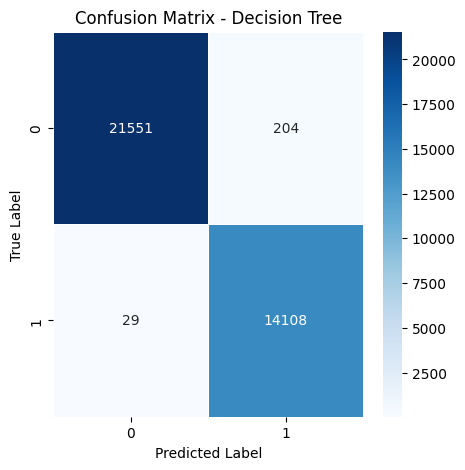

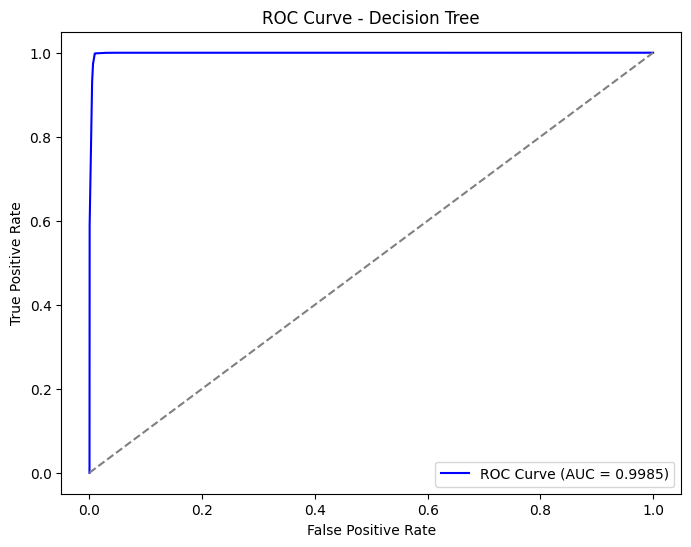

Decision Tree AUC-ROC Score: 0.9985


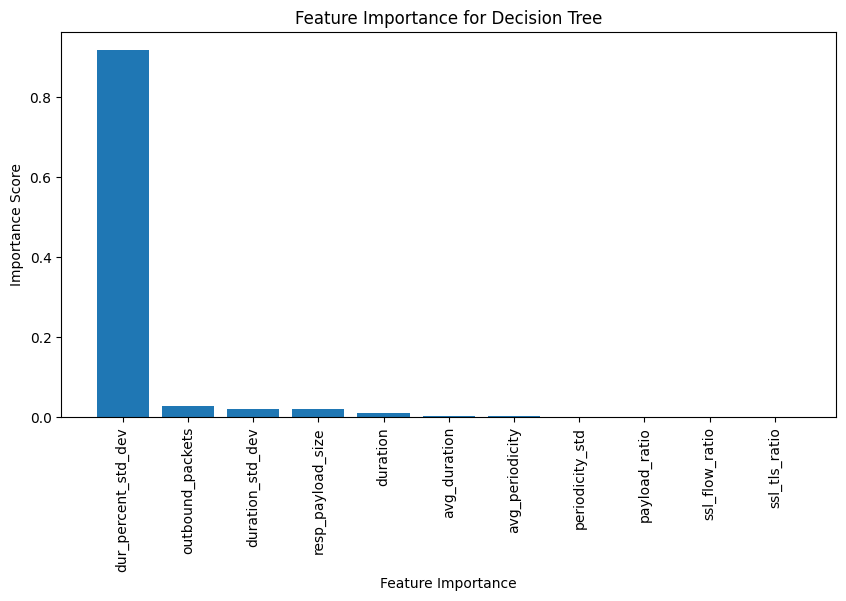

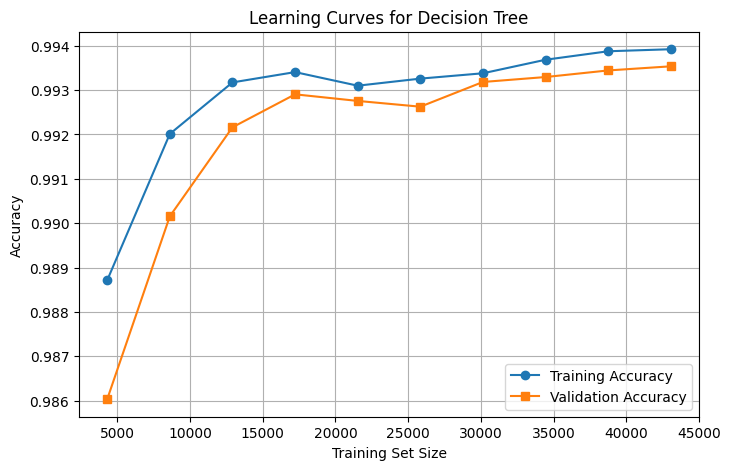

In [18]:
# Function to plot feature importance
def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 5))
    plt.bar(range(len(importances)), importances[sorted_idx], align="center")
    plt.xticks(range(len(importances)), np.array(feature_names)[sorted_idx], rotation=90)
    plt.xlabel("Feature Importance")
    plt.ylabel("Importance Score")
    plt.title("Feature Importance for Decision Tree")
    plt.show()

# Function to plot ROC curve
def plot_roc_auc(model, X_test, y_test):
    y_scores = model.predict_proba(X_test)[:, 1]  # Probability of positive class
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Reference diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Decision Tree")
    plt.legend()
    plt.show()
    
    return roc_auc

# Function to train, evaluate, and visualize results
def train_and_evaluate(model, model_name, use_kfold=False):
    start_time = time.perf_counter()
    model.fit(X_train, y_train)
    elapsed_time = time.perf_counter() - start_time

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    print(f"{model_name} Training Time: {elapsed_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {fscore:.4f}\n")
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, linewidths=0.5, fmt=".0f", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    
    # Plot ROC-AUC
    roc_auc = plot_roc_auc(model, X_test, y_test)
    print(f"{model_name} AUC-ROC Score: {roc_auc:.4f}")

    # Plot feature importance
    plot_feature_importance(model, feature_names=X_train.columns)

    # Plot learning curves
    cv = StratifiedKFold(n_splits=5) if use_kfold else 5
    train_sizes = np.linspace(0.1, 1, 10)
    train_sizes, train_scores, validation_scores = learning_curve(
        model, X_train, y_train, train_sizes=train_sizes, cv=cv, scoring='accuracy', n_jobs=-1
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores_mean, label='Training Accuracy', marker='o')
    plt.plot(train_sizes, validation_scores_mean, label='Validation Accuracy', marker='s')
    plt.ylabel('Accuracy')
    plt.xlabel('Training Set Size')
    plt.title(f'Learning Curves for {model_name}')
    plt.legend()
    plt.grid()
    plt.show()

# Train and Evaluate Decision Tree
dt_model = DecisionTreeClassifier(
    max_depth=6,
    min_samples_split=8,
    min_samples_leaf=10,
    max_leaf_nodes=20,
    ccp_alpha=0.0,
    random_state=42
)

train_and_evaluate(dt_model, "Decision Tree", use_kfold=True)


# Random Forest

Random Forest Training Time: 0.34 seconds
Accuracy: 0.9976
Precision: 0.9976
Recall: 0.9976
F1-score: 0.9976

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21755
           1       0.99      1.00      1.00     14137

    accuracy                           1.00     35892
   macro avg       1.00      1.00      1.00     35892
weighted avg       1.00      1.00      1.00     35892



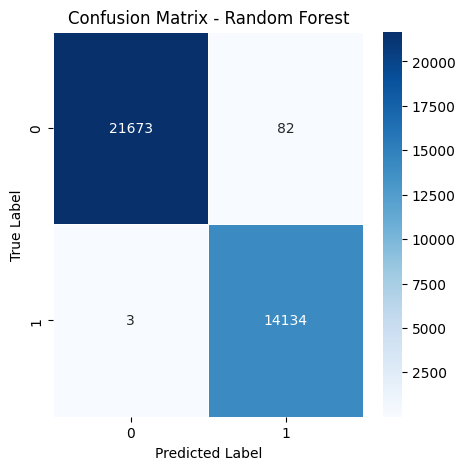

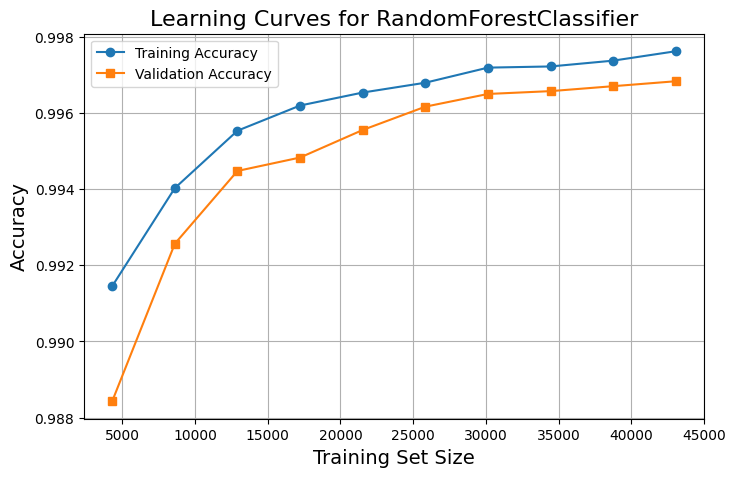

In [19]:
# Function to plot learning curves
def plot_learning_curves(estimator, X, y, train_sizes, cv):
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=cv, scoring='accuracy', n_jobs=-1
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores_mean, label='Training Accuracy', marker='o')
    plt.plot(train_sizes, validation_scores_mean, label='Validation Accuracy', marker='s')
    
    plt.ylabel('Accuracy', fontsize=14)
    plt.xlabel('Training Set Size', fontsize=14)
    title = f'Learning Curves for {type(estimator).__name__}'
    plt.title(title, fontsize=16)
    plt.legend()
    plt.grid()
    plt.show()

# Function to train, evaluate, and visualize results
def train_and_evaluate(model, model_name, use_kfold=False):
    start_time = time.perf_counter()
    model.fit(X_train, y_train)
    elapsed_time = time.perf_counter() - start_time

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    print(f"{model_name} Training Time: {elapsed_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {fscore:.4f}\n")
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, linewidths=0.5, fmt=".0f", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    
    # Plot learning curves
    cv = StratifiedKFold(n_splits=5) if use_kfold else 5
    plot_learning_curves(model, X_train, y_train, train_sizes=np.linspace(0.1, 1, 10), cv=cv)

# Train and Evaluate Random Forest
# rf_model = RandomForestClassifier(n_estimators=70, max_depth=9, random_state=42, n_jobs=-1)
rf_model = RandomForestClassifier(
    n_estimators=100,        # Increase tree count for stability
    max_depth=10,             # Limit depth
    min_samples_split=8,    # Min samples for node split
    min_samples_leaf=20,      # Min samples per leaf
    max_features='sqrt',     # Feature selection per tree
    random_state=42,
    n_jobs=-1 
)
train_and_evaluate(rf_model, "Random Forest", use_kfold=True)

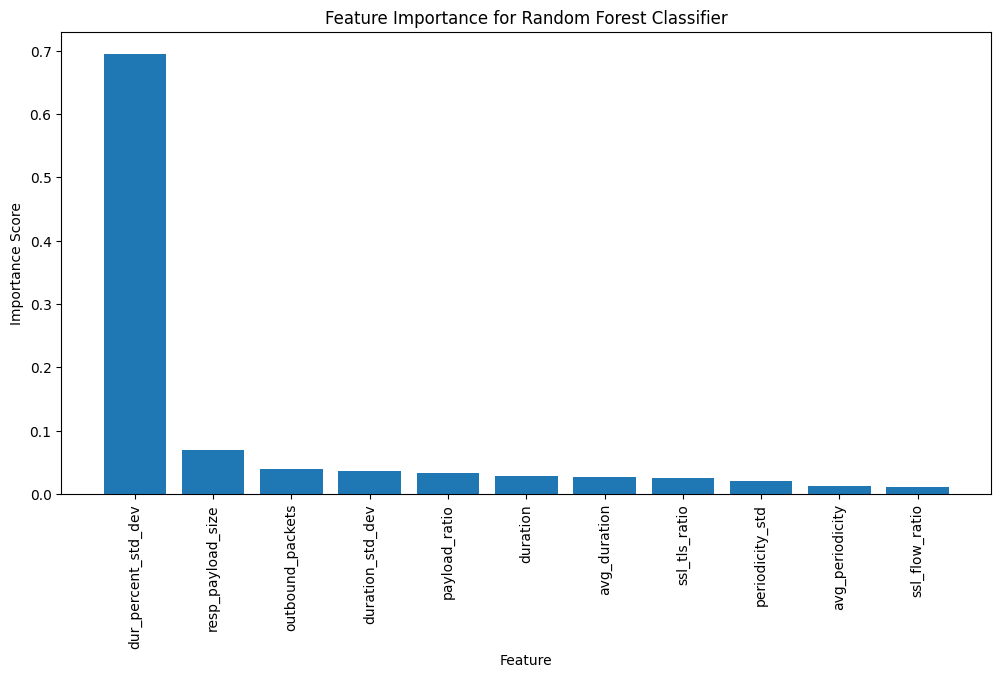

In [20]:
# Get feature importance
feature_importances = rf_model.feature_importances_

# Get feature names (assuming you have a DataFrame X_train)
feature_names = X_train.columns  

# Sort feature importance values
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align='center')
plt.xticks(range(len(feature_importances)), np.array(feature_names)[sorted_idx], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Importance for Random Forest Classifier")
plt.show()


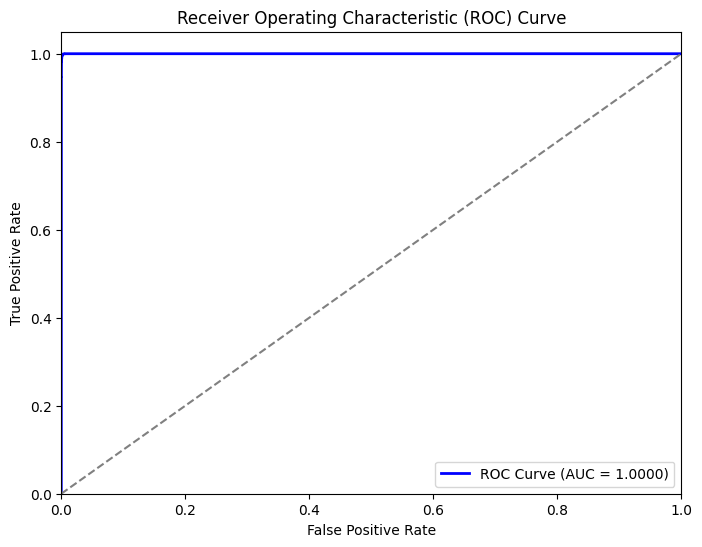

In [21]:
# Predict probabilities
y_proba = rf_model.predict_proba(X_test)[:, 1]  # Probability of ransomware class

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Random chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# XG Boost

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [22:49:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Training Time: 0.22 seconds
Accuracy: 0.9945
Precision: 0.9945
Recall: 0.9945
F1-score: 0.9945
ROC-AUC Score: 0.9999

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     21755
           1       1.00      0.99      0.99     14137

    accuracy                           0.99     35892
   macro avg       1.00      0.99      0.99     35892
weighted avg       0.99      0.99      0.99     35892



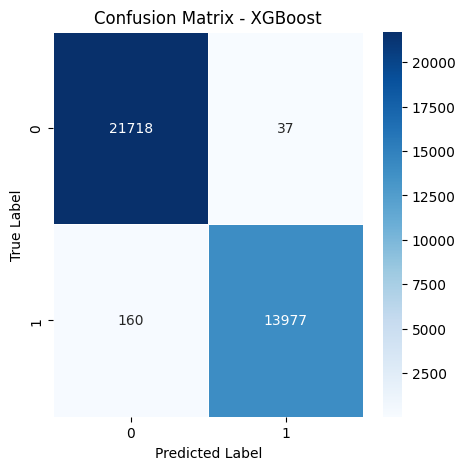

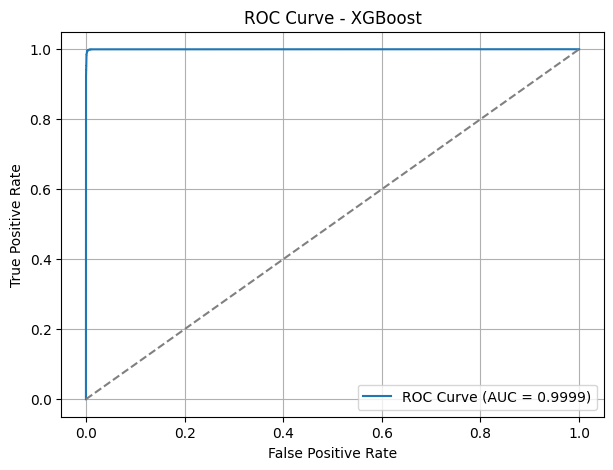

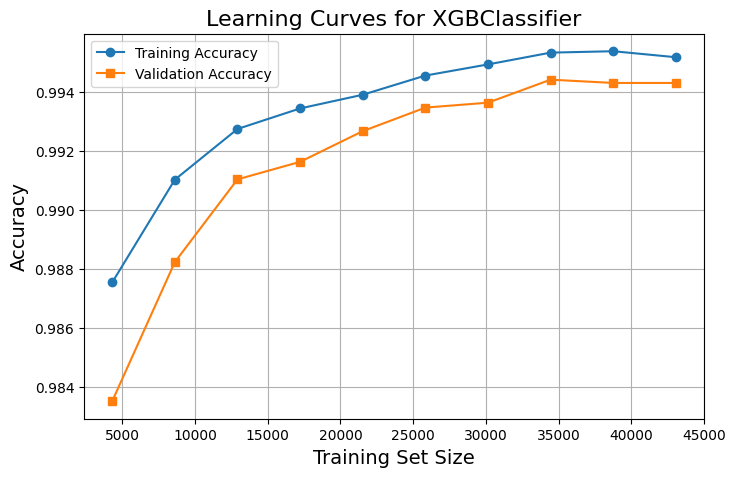

In [22]:
def train_and_evaluate(model, model_name, use_kfold=False):
    start_time = time.perf_counter()
    model.fit(X_train, y_train)
    elapsed_time = time.perf_counter() - start_time

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba)  # Compute ROC-AUC score

    print(f"{model_name} Training Time: {elapsed_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {fscore:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}\n")
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, linewidths=0.5, fmt=".0f", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot learning curves
    cv = StratifiedKFold(n_splits=5) if use_kfold else 5
    plot_learning_curves(model, X_train, y_train, train_sizes=np.linspace(0.1, 1, 10), cv=cv)

# Train and Evaluate XGBoost with ROC-AUC
# xgb_model = XGBClassifier(n_estimators=70, max_depth=6, learning_rate=0.005, use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
xgb_model = XGBClassifier(
    max_depth=8,                # Deeper trees for more learning capacity
    learning_rate=0.005,          # Standard learning rate
    n_estimators=70,           # More trees for stronger learning
    min_child_weight=3,         # Less conservative splits
    gamma=0.1,                  # Slightly relaxed regularization
    subsample=0.9,              # More data per tree
    colsample_bytree=0.9,       # More features per tree
    eval_metric="logloss",          # Using ROC-AUC for imbalanced class evaluation
    random_state=42,            # Reproducibility
    use_label_encoder=False,    # Avoid deprecation warning
    n_jobs=-1                   # Utilize all CPU cores
)

train_and_evaluate(xgb_model, "XGBoost", use_kfold=True)


<Figure size 900x700 with 0 Axes>

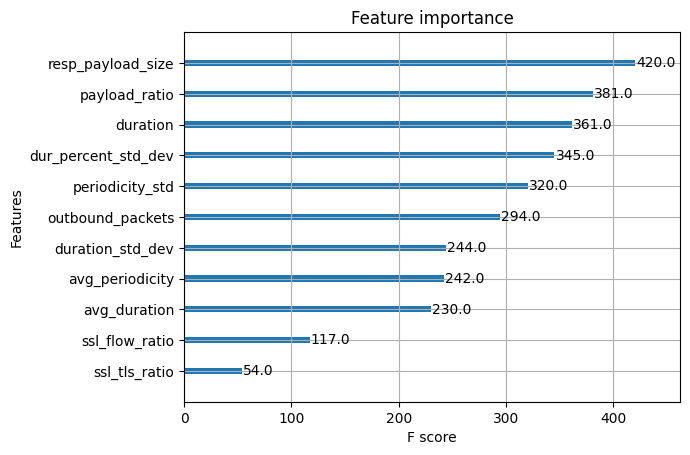

In [23]:
# plot feature importance
plt.figure(figsize=(9,7))
plot_importance(xgb_model)
pyplot.show()

In [24]:
model_path = r'models'

# Save models
joblib.dump(rf_model,os.path.join(model_path, 'random_forest_New.pkl'))
joblib.dump(xgb_model,os.path.join(model_path, 'xgboost_New.pkl'))
joblib.dump(dt_model,os.path.join(model_path, 'decision_tree_New.pkl'))

['models\\decision_tree_New.pkl']